# Data Preprocessing

In [4]:
import os
import re
import glob
import numpy as np
import pandas as pd
from sonarlight import Sonar
from datetime import datetime, timedelta

time_col = 'datetime'
depth_col = 'water_depth'

sonar_cols = [
    time_col,
    'survey',
    depth_col,
    'min_range',
    'max_range',
    'frames',
    'latitude',
    'longitude',
    'gps_speed',
    'gps_heading',
    'gps_altitude'
]

combined_cols = [
    "datetime", 
    "site",
    "frame_path",
    "sonar_prim",
    "water_depth",
    "latitude",
    "longitude",
    "gps_speed",
    "gps_heading",
    "gps_altitude",
]

def stretch_column(col, new_length):
    """
    Stretch column using interpolation to a specified length.
    
    Args:
        col (numpy array): Numpy array of numerical data.
        new_length (int): Desired length of the column.
    """

    old_indices = np.linspace(0, 1, len(col))
    new_indices = np.linspace(0, 1, new_length)
    stretched_col = np.interp(new_indices, old_indices, col)
    return stretched_col


def adjust_channel(df, channel='primary', pad_value=np.nan, mask_below_bottom=False, trunc_max_depth=False):
    """
    Dynamically stretches and pads sonar channel image based on maximum scanning distance.
    
    Args:
        sonar (Sonar Object): Sonar object from the sonarlight library based on an sl2 or sl3 file.
        channel (str): The sonar channel to adjust.
        pad_value (float): Value to use as padding beyond significant readings
        mask_below_bottom (bool): If true, replaces sonar readings below max depth with a pad value
        trunc_max_depth (bool): If true, truncates the sonar frame at max depth instead of max range
    """

    df_prim = df.query(f"survey == '{channel}'")
    prim = np.stack(df_prim['frames'])
    max_range = max(df_prim['max_range'])
    min_range = min(df_prim['max_range'])
    max_depth = max(df_prim['water_depth'])
    new_col_len = int(prim.shape[1] * (max_range / min_range))
    cols_to_add = new_col_len - prim.shape[1]

    adj_prim = []
    for i, (col, range, depth) in enumerate(zip(prim, df_prim['max_range'], df_prim['water_depth'])):
        print(f"Adjusting {channel} channel frames ({i}/{len(prim)})...\r", end="")
        stretched_col_len = 0

        # Stretch column if necessary
        if max_range > min_range:
            stretch_factor = (range - min_range) / (max_range - min_range)
            stretched_col_len = len(col) + int(stretch_factor * cols_to_add)
            col = stretch_column(col, stretched_col_len)

        # Pad column if necessary
        adj_col = np.pad(col, (0, new_col_len - stretched_col_len), 
                         'constant', constant_values=np.nan)
        
        if mask_below_bottom:
            bottom_idx = int(len(adj_col) * (depth / max_range))
            adj_col[bottom_idx:] = pad_value
        
        if trunc_max_depth:
            max_depth_idx = int(len(adj_col) * (max_depth / max_range))
            adj_col = adj_col[:max_depth_idx + 1]

        adj_prim.append(adj_col)

    return np.array(adj_prim)

def grid_resample(df, col, dt, start, end, interval=timedelta(seconds=0.1)):
    """
    Samples sonar pings regularly within a time period from an irregular dataset.
    Intervals with no entries are propagated from the nearest interval.
    Accompanying data (depth, gps) is approximated from the nearest data point to the specified time

    Parameters:
        df (pandas DataFrame): The dataframe to sample from
        col (str): Name of the column to sample from
        dt (datetime): Time the interval is centered around
        start (datetime): Sample start time
        end (datetime): Sample end time
        interval (timedelta): Regular sampling interval
    """

    grid_sample = []
    incomplete = False

    # Find depth & gps at closest data point
    closest_idx = (df[time_col] - dt).abs().idxmin()
    closest_row = df.loc[closest_idx]
    gps_stats = [closest_row[stat] for stat in sonar_cols[6:]]
    depth = closest_row[depth_col]
    
    if closest_row[time_col] < start or closest_row[time_col] > end:
        print(f"\tNo data found between {start} and {end}. Substituting with data from {closest_row[time_col]}.")

    # Find pings within interval
    grid_dim = int((end - start) / interval)

    interval_start = start
    
    while interval_start < end:
        interval_end = interval_start + interval
        entries = df[(df[time_col] >= interval_start) & 
                     (df[time_col] < interval_end)]

        values = list(entries[col])

        if entries.shape[0] >= 1:
            grid_sample.append(np.mean(values, axis=0))
        else:
            grid_sample.append([])

        interval_start = interval_end
    
    # forward fill
    prev_frame = grid_sample[0]

    for i in range(len(grid_sample)):
        if len(grid_sample[i]) == 0:
            grid_sample[i] = prev_frame
        else:
            prev_frame = grid_sample[i]
    
    # backward fill
    next_frame = grid_sample[-1]

    for i in range(len(grid_sample) - 1, -1, -1):
        if len(grid_sample[i]) == 0:
            grid_sample[i] = next_frame
        else:
            next_frame = grid_sample[i]

    if len(grid_sample) != int(grid_dim):
        incomplete = True

    return grid_sample, depth, gps_stats, incomplete

def frame_sort_key(filename):
    match = re.search(r"frame(\d+)", filename)
    return int(match.group(1)) if match else float('inf')

def load_and_combine_data(data_dir, out_path, sonar_frame_len=2, ping_interval=1, tz_offset=4):
    """
    Locate and align extracted video frames and sonar data and store in CSV specified by out_path. 
    Sonar echograms are broken into localized echograms to accompany each frame.
    
    Assumes the following directory structure within data_dir:
    data_dir
        2025-06-17
        ...
        2025-07-18
            images
                video1
                    frame1
                    ...
                    frameN
                ...
                videoN
            sonar
                sonar1
                ...
                sonarN
                

    Parameters:
        data_dir (str): Path to directory image and sonar data.
        out_path (str): Path to output CSV
        sonar_frame_len (int): Length of localized sonar echograms in seconds (default = 2)
        ping_interval (int): Interval between selected sonar pings in 10ths of a second (default = 1)
        tz_offset (int): Time zone offset of input sonar data in hours (default = 4)
    """

    # Find records from each date
    data_subdirs = next(os.walk(data_dir))[1]
    first = True

    for subdir in data_subdirs:
        # Find image directories and sonar files
        img_dir = os.path.join(data_dir, subdir, "images")
        sonar_dir = os.path.join(data_dir, subdir, "sonar")
        img_subdirs = sorted(next(os.walk(img_dir))[1])
        sonar_files = glob.glob(os.path.join(sonar_dir, "*.sl2")) + glob.glob(os.path.join(sonar_dir, "*.sl3"))
        df_list = []

        # Load and adjust sonar data
        for i, file in enumerate(sonar_files):
            print(f"Loading sonar records: {file} ({i + 1}/{len(sonar_files)})...\r")
    
            sonar = Sonar(file)
            df_prim = sonar.df.query(f"survey == 'primary'")[sonar_cols]
            df_list.append(df_prim)
    
        df_sonar = pd.concat(df_list, ignore_index=True).sort_values(by=time_col)
        df_sonar[time_col] = df_sonar[time_col] - timedelta(hours=tz_offset)
        print(f"\nLoaded {len(sonar_files)} sonar files with {len(df_sonar)} total records.")

        # Adjust sonar echogram to remove jumps in depth/range
        frames_adj = adjust_channel(df_sonar, pad_value=0, mask_below_bottom=True, trunc_max_depth=True).tolist()
        df_sonar["frames"] = frames_adj
        print(f"Adjusted primary channel sonar frames ({len(df_sonar) + 1}/{len(df_sonar)})")
        
        combined_dict = {col: [] for col in combined_cols}
        elapsed_time = dict() # track elapsed time for continued videos
        
        # Align image (video frame) paths with localized sonar echograms and gps data
        for i, dir_name in enumerate(img_subdirs):
            print(f"Loading video records and aligning with sonar data: {dir_name} ({i + 1}/{len(img_subdirs)})...\r")

            # Determine site and start time for each video
            dir_path = os.path.join(img_dir, dir_name)
            date_str = " ".join(dir_name.split("_")[2:4]) + "000"
            site = dir_name.split("_")[1]
            format_str = '%Y-%m-%d %H.%M.%S.%f'                
            dt_start = datetime.strptime(date_str, format_str)
            
            if date_str in elapsed_time.keys():
                print(f"Found continued video ({dir_name}) | Changing start time from {dt_start} to {dt_start + elapsed_time[date_str]}...")
                dt_start = dt_start + elapsed_time[date_str]
                
            else:
                elapsed_time[date_str] = timedelta()
            
            img_paths = sorted(glob.glob(os.path.join(dir_path, "*.jpg")), key=frame_sort_key)
            combined_dict["site"].extend([site] * len(img_paths))
            prev_td = timedelta()
    
            for path in img_paths:
                # Determine datetime and path for each image
                filename = os.path.splitext(os.path.basename(path))[0]
                _, ms = filename.split("_")
                ms = int(re.findall(r'\d+', ms)[0])
    
                dt = dt_start + timedelta(milliseconds=ms)
                elapsed_time[date_str] += timedelta(milliseconds=ms) - prev_td
                prev_td = timedelta(milliseconds=ms)
    
                combined_dict["datetime"].append(dt)
                combined_dict["frame_path"].append(path)

                # Determine interval for sampling sonar pings
                sf_start = dt - timedelta(seconds=sonar_frame_len / 2)
                sf_end = dt + timedelta(seconds=sonar_frame_len / 2)
                interval = timedelta(seconds=ping_interval / 10)

                # Sample sonar pings around time of frame
                # Collect localized echogram, determine average depth and gps stats
                sonar_frame, avg_depth, gps_stats, incomplete = grid_resample(df_sonar, "frames", dt, sf_start, sf_end, interval)
                
                if incomplete:
                    print(f"\tIncomplete sonar frame for {os.path.basename(path)}. Skipping...")
                    combined_dict["sonar_prim"].append(None)
                else:
                    combined_dict["sonar_prim"].append(sonar_frame)
                    
                combined_dict["water_depth"].append(float(avg_depth))
                combined_dict["latitude"].append(float(gps_stats[0]))
                combined_dict["longitude"].append(float(gps_stats[1]))
                combined_dict["gps_speed"].append(float(gps_stats[2]))
                combined_dict["gps_heading"].append(float(gps_stats[3]))
                combined_dict["gps_altitude"].append(float(gps_stats[4]))
                
                print(f"\tAligning frames: ({timedelta(milliseconds=ms)}/{timedelta(seconds=len(img_paths))})", end="\r")
                
            print()
            
        print(f"\nLoaded {len(img_subdirs)} sonar files and aligned {len(combined_dict["datetime"])} total video frames with sonar data.\n\n")
        df_single = pd.DataFrame(combined_dict)
        if first:
            df_single.to_csv(out_path, index=False, mode="w", header=True)
        else:
            df_single.to_csv(out_path, index=False, mode="a", header=False)
        first = False

    print(f"Results saved to {out_path}")

#### Export Sonar Dataframe as CSV

In [6]:
sonar_dir = 'data/2025-07-30/sonar'
files = glob.glob(os.path.join(sonar_dir, "*.sl2")) + \
        glob.glob(os.path.join(sonar_dir, "*.sl3"))

for file in files:
    filename = os.path.basename(file)
    dest_path = os.path.join(sonar_dir, os.path.splitext(filename)[0] + ".csv")

    if os.path.exists(dest_path):
        print(f"Skipping {dest_path}...")
        continue
    
    # Load SL2 file
    sl2 = Sonar(file)
    df = sl2.df
    df.reset_index(drop=True, inplace=True)

    df.to_csv(dest_path)
    print(f"Exported {filename} to {dest_path}")

print("Done!")

Exported Sonar_LGV_2025-07-30_09.44.000.sl2 to data/2025-07-30/sonar\Sonar_LGV_2025-07-30_09.44.000.csv
Exported Sonar_LGV_2025-07-30_10.04.000.sl2 to data/2025-07-30/sonar\Sonar_LGV_2025-07-30_10.04.000.csv
Exported Sonar_LGV_2025-07-30_10.22.000.sl2 to data/2025-07-30/sonar\Sonar_LGV_2025-07-30_10.22.000.csv
Done!


#### Compile video and sonar data

In [5]:
data_dir = "data"
out_file = "combined.csv"

# out_file = os.path.join(out_dir, "combined.csv")

load_and_combine_data(data_dir, out_file)

Loading sonar records: data\2025-07-18\sonar\Sonar_NWB_2025-07-18_09.45.000.sl2 (1/6)...
Loading sonar records: data\2025-07-18\sonar\Sonar_NWB_2025-07-18_10.00.000.sl2 (2/6)...
Loading sonar records: data\2025-07-18\sonar\Sonar_NWB_2025-07-18_10.11.000.sl2 (3/6)...
Loading sonar records: data\2025-07-18\sonar\Sonar_SUNSET-INDIAN-2025-07-18_11.53.000.sl2 (4/6)...
Loading sonar records: data\2025-07-18\sonar\Sonar_SUNSET-INDIAN_2025-07-18_11.06.000.sl2 (5/6)...
Loading sonar records: data\2025-07-18\sonar\Sonar_SUNSET-INDIAN_2025-07-18_11.33.000.sl2 (6/6)...

Loaded 6 sonar files with 48948 total records.
Adjusted primary channel sonar frames (48949/48948)
Loading video records and aligning with sonar data: Video1080P_NWB_2025-07-18_09.45.22.000 (1/6)...
	Aligning frames: (0:08:21.966000/0:08:22)
Loading video records and aligning with sonar data: Video1080P_NWB_2025-07-18_10.00.55.000 (2/6)...
	No data found between 2025-07-18 10:05:18.966000 and 2025-07-18 10:05:20.966000. Substitutin

C:\Users\jmani\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_arraypad_impl.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
C:\Users\jmani\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_arraypad_impl.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


Adjusted primary channel sonar frames (20400/20399)
Loading video records and aligning with sonar data: Video1080P_SUNSET_2025-08-20_13.11.03.100 (1/3)...
	Aligning frames: (0:08:21.966000/0:08:22)
Loading video records and aligning with sonar data: Video1080P_SUNSET_2025-08-20_13.37.15.100 (2/3)...
	No data found between 2025-08-20 13:38:34.066000 and 2025-08-20 13:38:36.066000. Substituting with data from 2025-08-20 13:38:33.891000032.
	No data found between 2025-08-20 13:38:35.066000 and 2025-08-20 13:38:37.066000. Substituting with data from 2025-08-20 13:38:37.230999947.
	No data found between 2025-08-20 13:41:01.066000 and 2025-08-20 13:41:03.066000. Substituting with data from 2025-08-20 13:41:00.924999952.
	No data found between 2025-08-20 13:41:02.066000 and 2025-08-20 13:41:04.066000. Substituting with data from 2025-08-20 13:41:00.924999952.
	No data found between 2025-08-20 13:41:03.066000 and 2025-08-20 13:41:05.066000. Substituting with data from 2025-08-20 13:41:00.92499

# Prediction

#### Config

In [14]:
import random, os, glob, cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import contextily as cx
from tqdm import tqdm
%matplotlib inline

# Config
csv_path = "combined.csv"
pred_csv_path = "predictions.csv"
project_dir = "YOLO11_model"
dataset_name = "datasetv3"
project_name = "yolo11_training"
save_dir = os.path.join(project_dir, "runs", project_name)
save_name = "exp3"


# Load metadata
df = pd.read_csv(csv_path)
assert {"frame_path", "site"}.issubset(df.columns), "CSV must include frame_path and site"

# Load trained YOLO model
model = YOLO(os.path.join(save_dir, save_name, "weights/best.pt"))
class_names = model.names
print("Classes:", class_names)

Classes: {0: 'Algae', 1: 'Clam Shell', 2: 'Elodea Canadensis', 3: 'Eriocaulon Septangulare', 4: 'I. Lacustris', 5: 'Leaves', 6: 'M. Spicatum', 7: 'M. Tenellum', 8: 'Najas', 9: 'P. Amplifolius', 10: 'P. Gramineus', 11: 'P. Perfoliatus', 12: 'P. Praelongus', 13: 'P. Robbinsii', 14: 'P. Zosteriformis', 15: 'Snail', 16: 'Unknown Plant', 17: 'Vallisneria Americana'}


#### Display Example Predictions

{0: 'Algae', 1: 'Clam Shell', 2: 'Elodea Canadensis', 3: 'Eriocaulon Septangulare', 4: 'I. Lacustris', 5: 'Leaves', 6: 'M. Spicatum', 7: 'M. Tenellum', 8: 'Najas', 9: 'P. Amplifolius', 10: 'P. Gramineus', 11: 'P. Perfoliatus', 12: 'P. Praelongus', 13: 'P. Robbinsii', 14: 'P. Zosteriformis', 15: 'Snail', 16: 'Unknown Plant', 17: 'Vallisneria Americana'}

image 1/1 C:\Users\jmani\Local Documents\ALGAE\data\2025-07-30\images\Video1080P_LGV_2025-07-30_10.05.02.000\frame710_710966ms.jpg: 736x1280 9 Clam Shells, 1 Eriocaulon Septangulare, 259.8ms
Speed: 6.7ms preprocess, 259.8ms inference, 7.5ms postprocess per image at shape (1, 3, 736, 1280)
Site: LGV


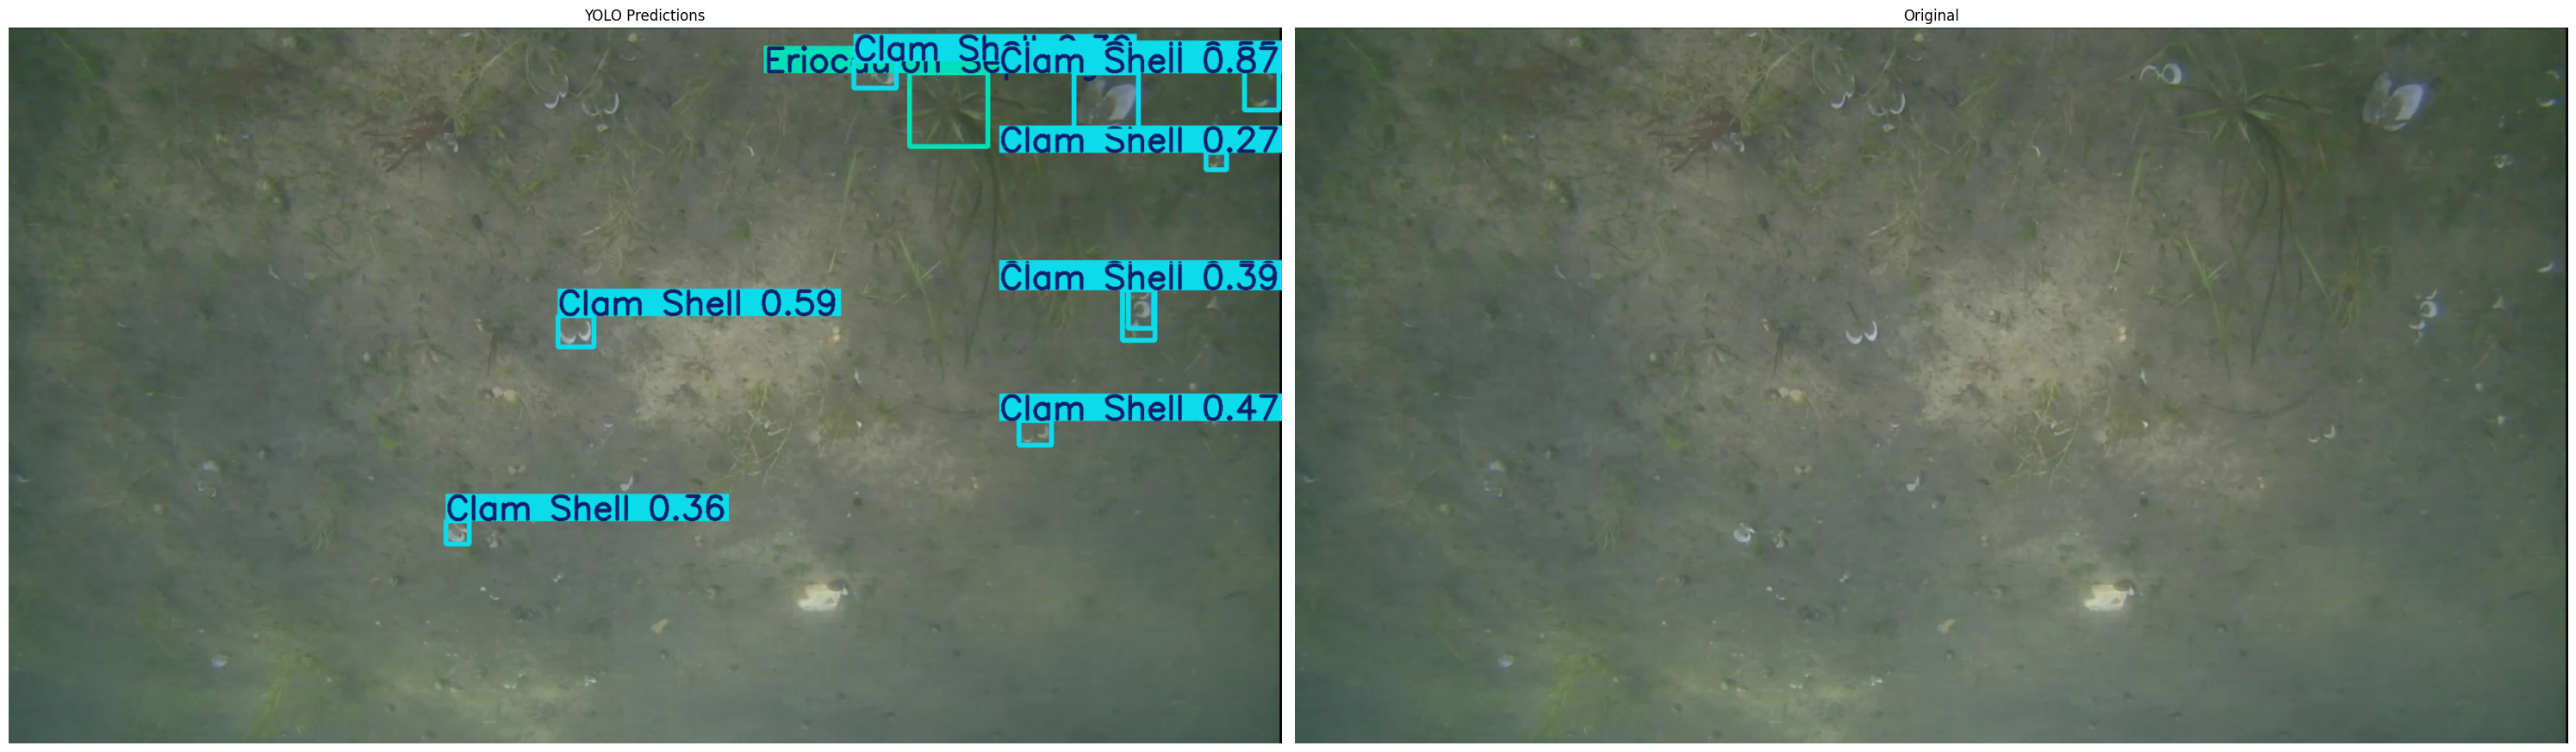


image 1/1 C:\Users\jmani\Local Documents\ALGAE\data\2025-08-22\images\Video1080P_BASIN_2025-08-22_12.10.30.000\frame519_522566ms.jpg: 736x1280 2 Clam Shells, 9.8ms
Speed: 3.8ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Site: BASIN


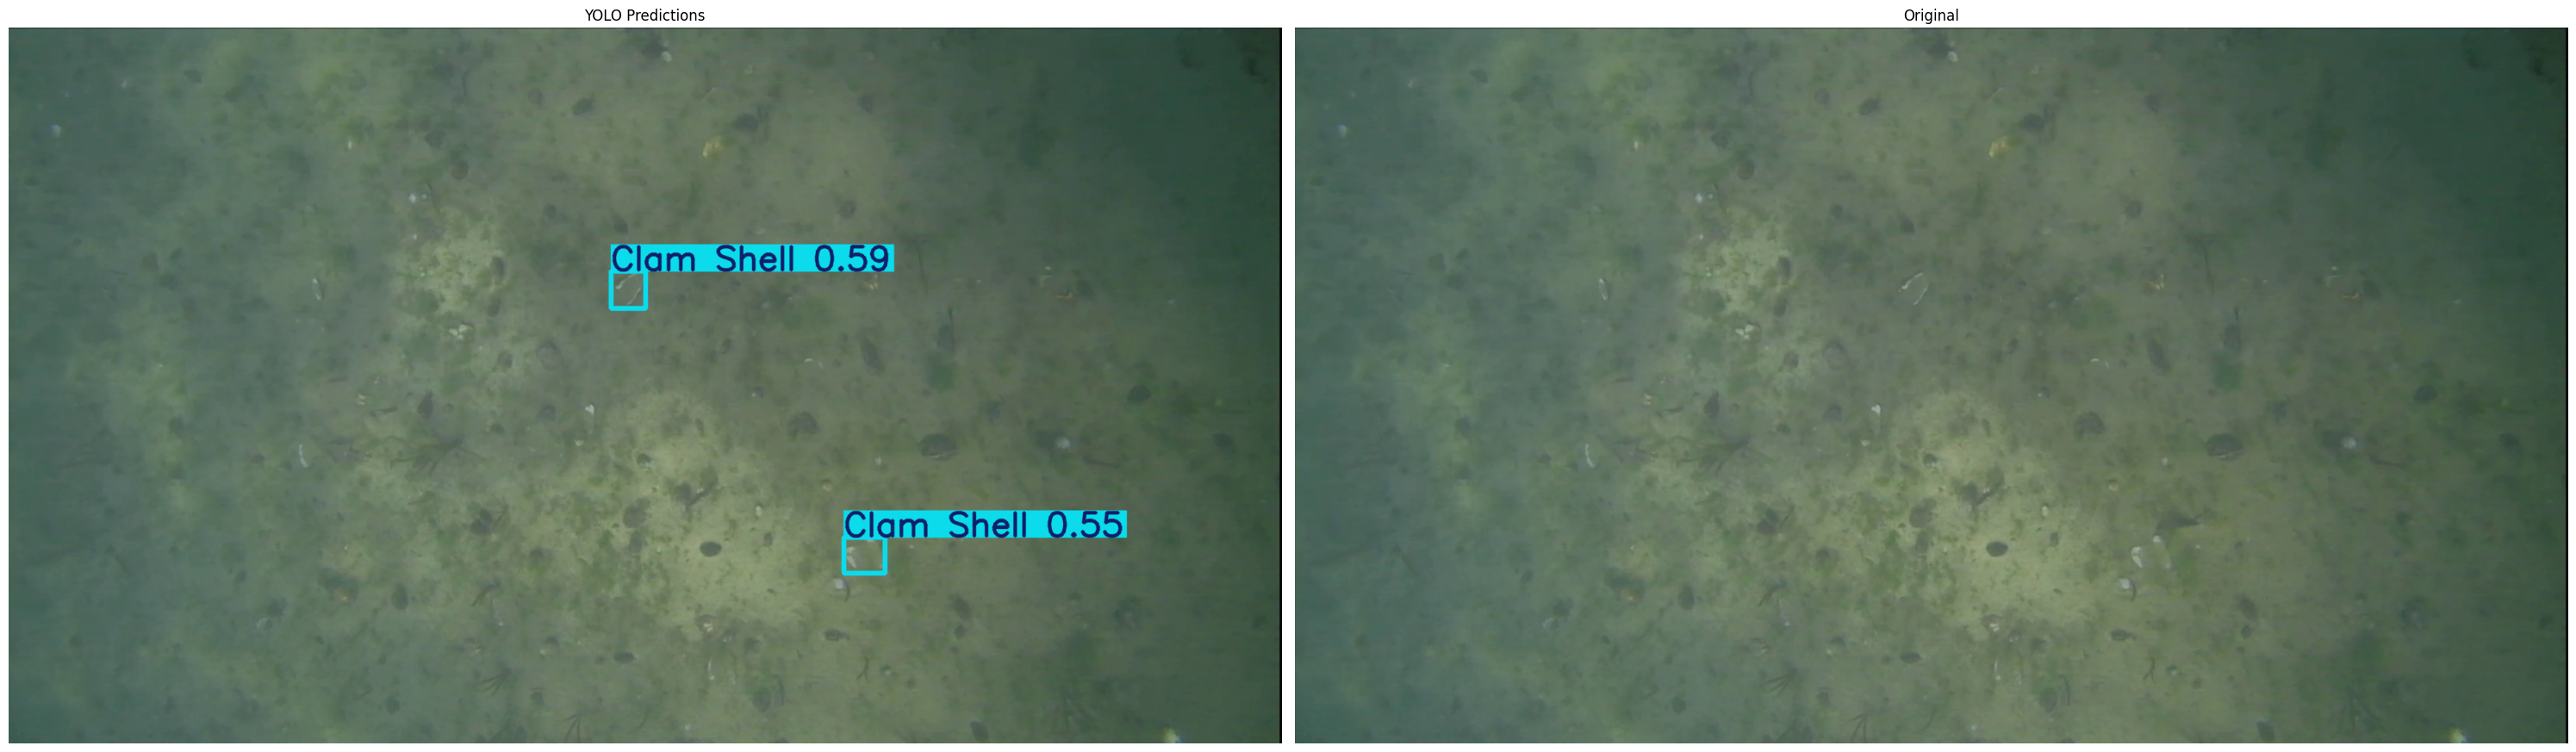


image 1/1 C:\Users\jmani\Local Documents\ALGAE\data\2025-09-29\images\Video1080P_LGV_2025-09-29_10.15.11.000_cont\frame177_177966ms.jpg: 736x1280 3 P. Robbinsiis, 10.5ms
Speed: 3.9ms preprocess, 10.5ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Site: LGV


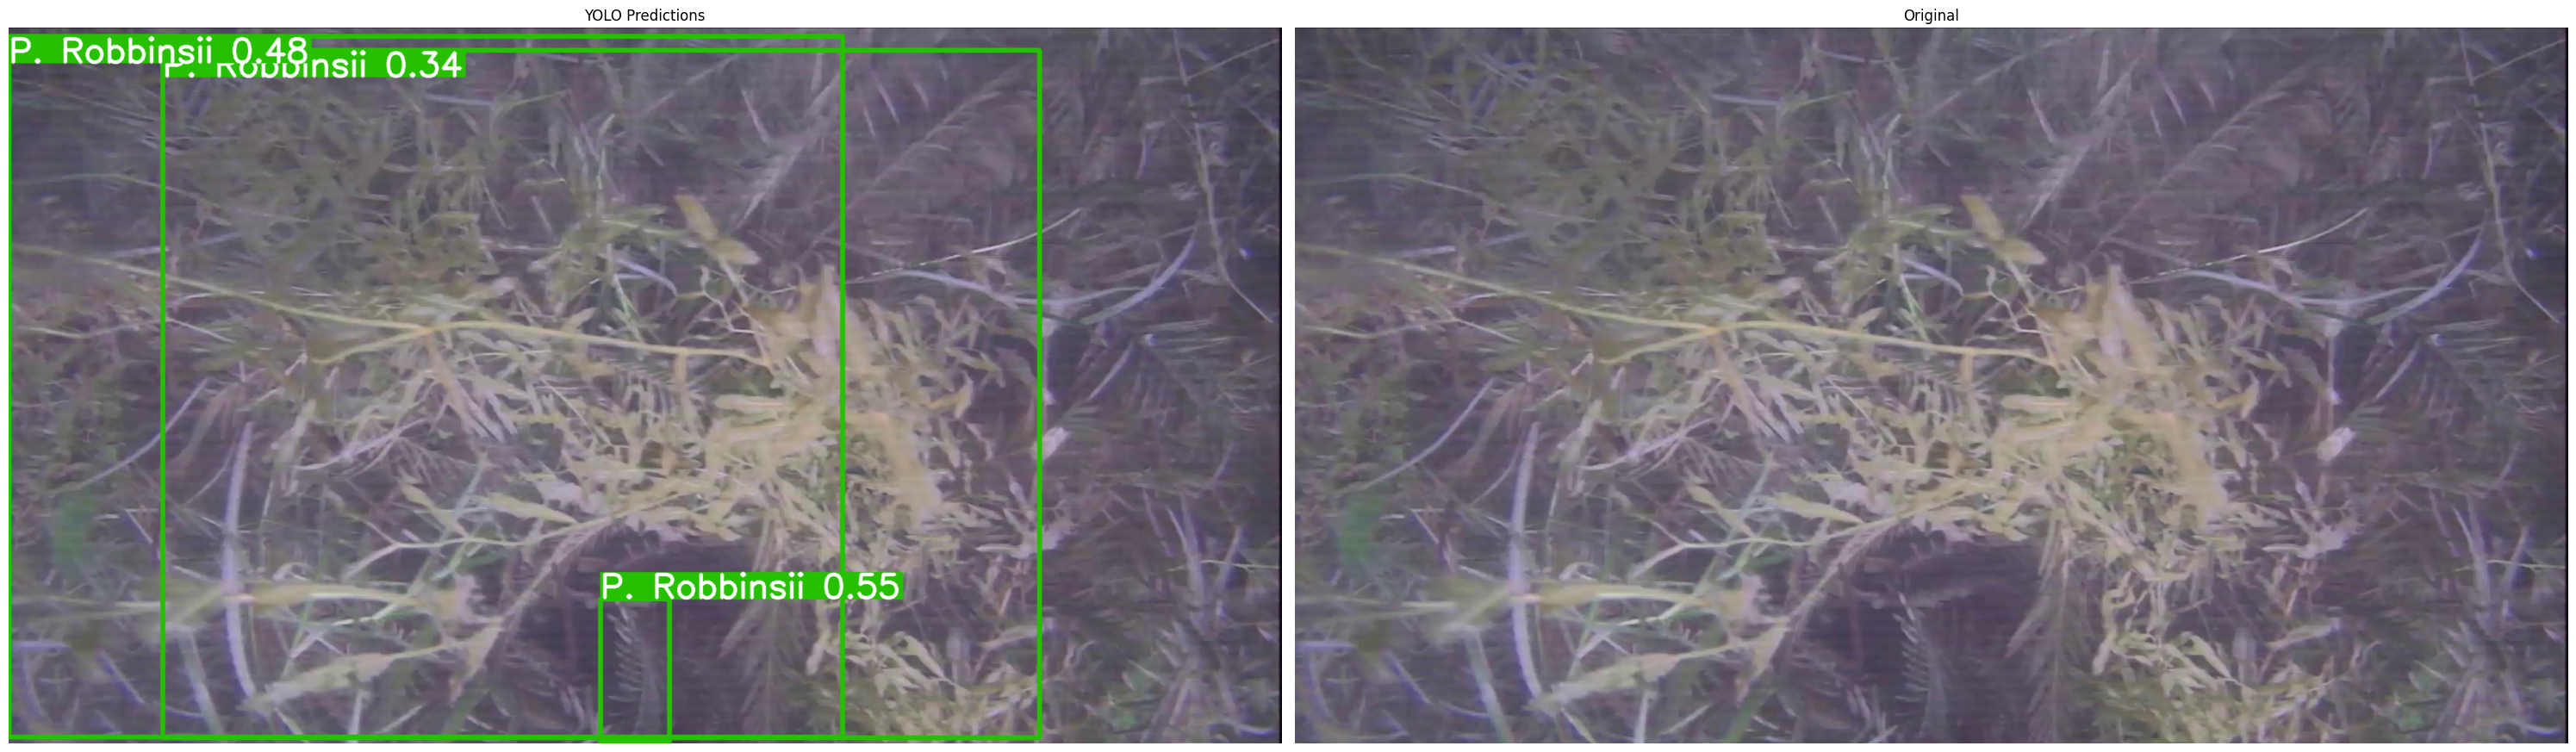


image 1/1 C:\Users\jmani\Local Documents\ALGAE\data\2025-11-13\images\Video1080P_HARRIS_2025-11-13_10.20.49.000\frame646_646966ms.jpg: 736x1280 (no detections), 9.9ms
Speed: 4.2ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Site: HARRIS


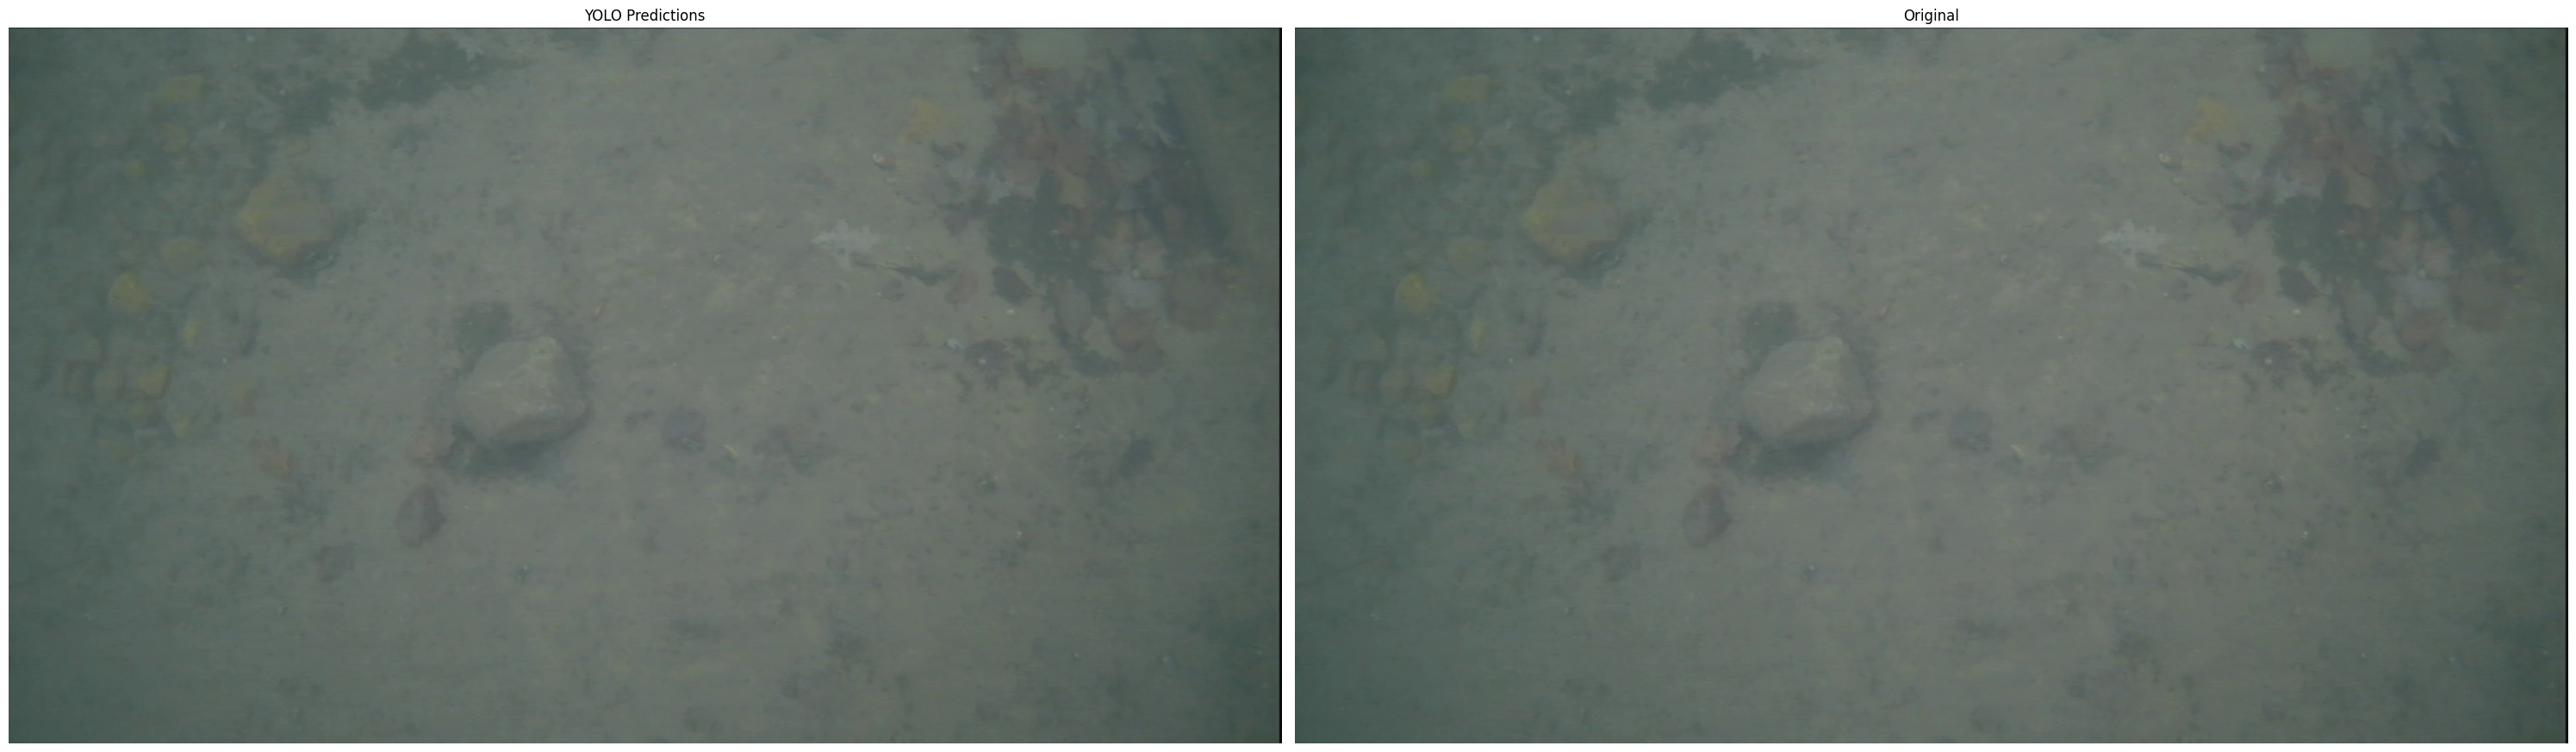

In [25]:
def show_prediction_sample(model, df, count=1, indices=None):
    """
    Display a number of random images or a number of images at select indices in the dataframe
                

    Parameters:
        model (YOLO model): Pretrained YOLO model object
        df (pd dataframe): Pandas dataframe object with image data
        count (int): number of random images to display (default = 1)
        indices (list(int)): indices of images to display (default = None)
    """
    image_files = df["frame_path"]
    sites = df["site"]
    class_names = model.names
    print(class_names)
    iterable = indices if indices else range(count)
    
    for i in iterable:
        image_idx = i if indices else random.choice(range(0, len(image_files) - 1))

        if image_idx >= len(image_files):
            print(f"Image index {image_idx} out of bounds. Skipping...")
            continue
            
        image_path = image_files[image_idx]
        site = sites[image_idx]
        results = model.predict(image_path, show=False)
        
        # Get YOLO's prediction image
        pred_img = results[0].plot()

        # Draw ground truth boxes
        gt_img = cv2.imread(image_path)
        label_path = image_path.replace("\\images\\", "\\labels\\").rsplit(".", 1)[0] + ".txt"
        h, w, _ = gt_img.shape
        gt_counts = dict()
        
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    x1, y1 = int((x - bw/2) * w), int((y - bh/2) * h)
                    x2, y2 = int((x + bw/2) * w), int((y + bh/2) * h)

                    # Get class name
                    class_name = class_names[int(cls)] if int(cls) in class_names else str(int(cls))
                    gt_counts[class_name] = gt_counts[class_name] + 1 if class_name in gt_counts.keys() else 1
                    
                    # Draw box and label
                    cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(gt_img, class_name, (x1, max(y1 - 5, 10)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Display ground truth counts
        print(f"Site: {site}")
        
        # Convert BGR → RGB for plotting
        pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
        gt_img_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

        # Display side by side
        fig, axes = plt.subplots(1, 2, figsize=(30, 15))
        axes[0].imshow(pred_img_rgb)
        axes[0].set_title("YOLO Predictions")
        axes[0].axis("off")
        
        axes[1].imshow(gt_img_rgb)
        axes[1].set_title("Original")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()
    
show_prediction_sample(model, df, 4)

#### Image-level Species Presence per Site

In [28]:
# Run inference with image-level presence/absence
results_list = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    dt = row["datetime"]
    image_path = row["frame_path"]
    site = row["site"]

    if not os.path.exists(image_path):
        continue

    results = model.predict(image_path, verbose=False)

    # Track which classes were present in this image
    detected_classes = set()

    for r in results:
        if r.boxes is not None and len(r.boxes.cls) > 0:
            for cls_id in r.boxes.cls.cpu().numpy().astype(int):
                detected_classes.add(class_names[cls_id])

    # Record one row per detected class for this image
    for c in detected_classes:
        results_list.append({"datetime": dt, "site": site, "class": c, "frame_path": image_path})

# Aggregate per-site presence counts
pred_df = pd.DataFrame(results_list)
pred_df.to_csv(pred_csv_path, index=False)
print(f"Results saved to {pred_csv_path}")

100%|████████████████████████████████████████████████████████████████████████████| 39216/39216 [14:16<00:00, 45.79it/s]


Results saved to predictions.csv


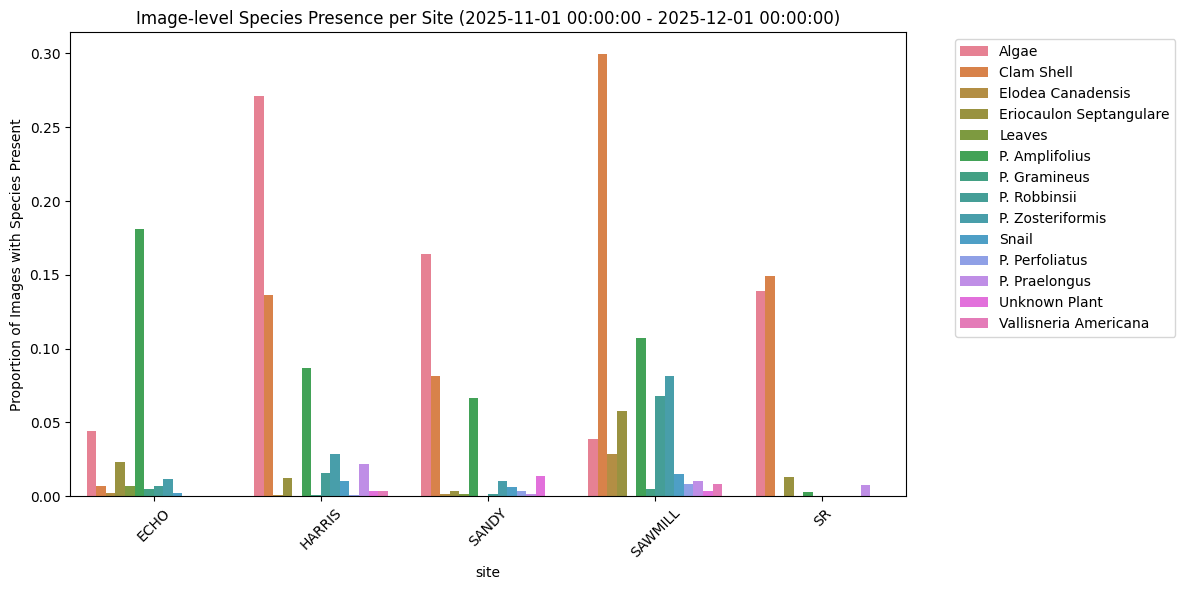

class       Algae  Clam Shell  Elodea Canadensis  Eriocaulon Septangulare  \
site                                                                        
ECHO     0.044186    0.006977           0.002326                 0.023256   
HARRIS   0.271418    0.136088           0.001137                 0.012509   
SANDY    0.164366    0.081556           0.001255                 0.003764   
SAWMILL  0.039116    0.299320           0.028912                 0.057823   
SR       0.138743    0.149215           0.000000                 0.013089   

class      Leaves  P. Amplifolius  P. Gramineus  P. Perfoliatus  \
site                                                              
ECHO     0.006977        0.181395      0.004651        0.000000   
HARRIS   0.000379        0.086808      0.001137        0.000758   
SANDY    0.001255        0.066499      0.000000        0.003764   
SAWMILL  0.000000        0.107143      0.005102        0.008503   
SR       0.000000        0.002618      0.000000        0.000000   

class    P. Praelongus  P. Robbinsii  P. Zosteriformis     Snail  \
site                                                               
ECHO          0.000000      0.006977          0.011628  0.002326   
HARRIS        0.021986      0.015542          0.028431  0.010235   
SANDY         0.001255      0.001255          0.010038  0.006274   
SAWMILL       0.010204      0.068027          0.081633  0.015306   
SR            0.007853      0.000000          0.000000  0.000000   

class    Unknown Plant  Vallisneria Americana  
site                                           
ECHO          0.000000               0.000000  
HARRIS        0.003412               0.003791  
SANDY         0.013802               0.000000  
SAWMILL       0.003401               0.008503  
SR            0.000000               0.000000

In [55]:
start_time = "2025-11-01 00:00:00"
end_time   = "2025-12-01 00:00:00"

pred_df = pd.read_csv(pred_csv_path)

pred_df = pred_df[
    (pred_df["datetime"] >= start_time) &
    (pred_df["datetime"] <= end_time)
]

if pred_df.empty:
    print("No detections found in any images within the timeframe.")
else:
    # Count how many images per site had each species present
    presence_counts = (
        pred_df.groupby(["site", "class"])["frame_path"]
        .nunique()
        .reset_index(name="n_images_with_species")
    )

    # Also get number of total images per site
    total_images_per_site = df.groupby("site")["frame_path"].nunique().rename("total_images")
    presence_counts = presence_counts.merge(total_images_per_site, on="site", how="left")

    # Compute proportion of images per site containing each species
    presence_counts["presence_rate"] = (
        presence_counts["n_images_with_species"] / presence_counts["total_images"]
    )

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=presence_counts, x="site", y="presence_rate", hue="class")
    plt.title(f"Image-level Species Presence per Site ({start_time} - {end_time})")
    plt.ylabel("Proportion of Images with Species Present")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Optional: table view
    summary_table = presence_counts.pivot(index="site", columns="class", values="presence_rate").fillna(0)
    display(summary_table)

#### Site-specific Species Presence Distribution

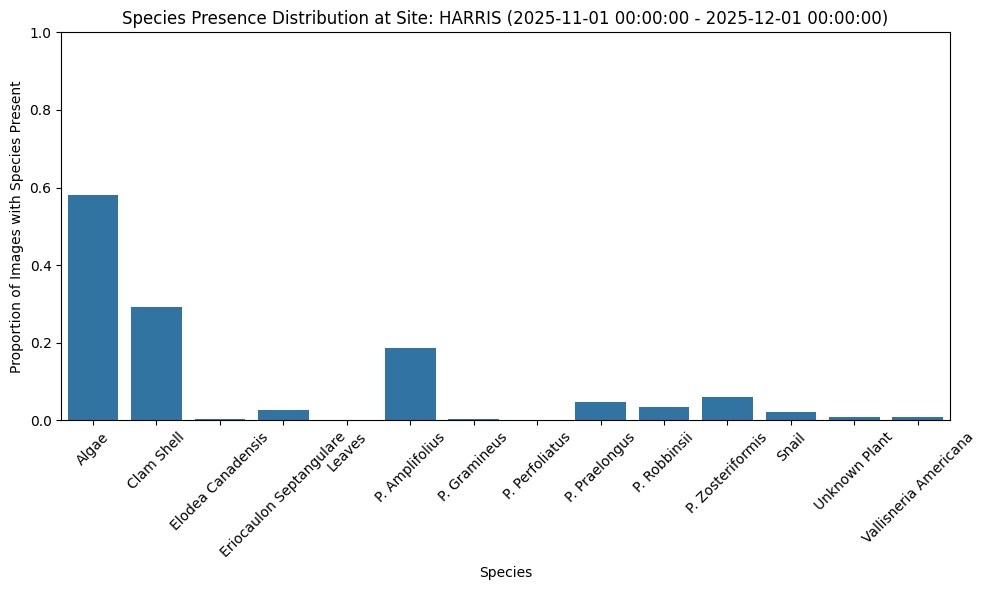

class  n_images_with_species  proportion
0                     Algae                    716    0.581641
1                Clam Shell                    359    0.291633
2         Elodea Canadensis                      3    0.002437
3   Eriocaulon Septangulare                     33    0.026807
4                    Leaves                      1    0.000812
5            P. Amplifolius                    229    0.186028
6              P. Gramineus                      3    0.002437
7            P. Perfoliatus                      2    0.001625
8             P. Praelongus                     58    0.047116
9              P. Robbinsii                     41    0.033306
10         P. Zosteriformis                     75    0.060926
11                    Snail                     27    0.021933
12            Unknown Plant                      9    0.007311
13    Vallisneria Americana                     10    0.008123

In [48]:
# Pick the site you want
site_of_interest = "HARRIS"
start_time = "2025-11-01 00:00:00"
end_time   = "2025-12-01 00:00:00"

# Load predictions
pred_df = pd.read_csv(pred_csv_path)
pred_df = pred_df[
    (pred_df["datetime"] >= start_time) &
    (pred_df["datetime"] <= end_time)
]
site_df = pred_df[pred_df["site"] == site_of_interest]

if site_df.empty:
    print(f"No predictions found for site '{site_of_interest}' between {start_time} and {end_time}")
else:
    # Total unique images at this site
    total_images = site_df["frame_path"].nunique()

    # Count how many images at this site contained each species
    counts = (site_df.groupby("class")["frame_path"]
                        .nunique()
                        .reset_index(name="n_images_with_species"))

    # Convert to proportions
    counts["proportion"] = counts["n_images_with_species"] / total_images

    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(data=counts, x="class", y="proportion")
    plt.title(f"Species Presence Distribution at Site: {site_of_interest} ({start_time} - {end_time})")
    plt.ylabel("Proportion of Images with Species Present")
    plt.xlabel("Species")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    display(counts)

#### Species-specific Distribution Across Sites

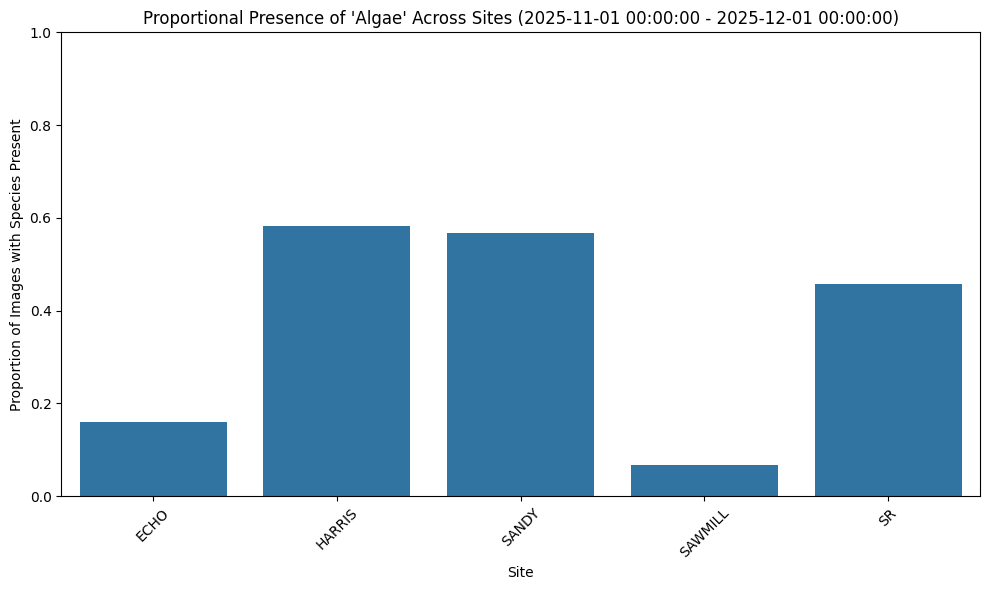

site  n_images_with_species  total_images  proportion
0     ECHO                     19           119    0.159664
1   HARRIS                    716          1231    0.581641
2    SANDY                    131           231    0.567100
3  SAWMILL                     23           342    0.067251
4       SR                     53           116    0.456897

In [50]:
# Pick the species you want to analyze
species_of_interest = "Algae"
start_time = "2025-11-01 00:00:00"
end_time   = "2025-12-01 00:00:00"

# Load predictions
pred_df = pd.read_csv(pred_csv_path)
pred_df = pred_df[
    (pred_df["datetime"] >= start_time) &
    (pred_df["datetime"] <= end_time)
]
species_df = pred_df[pred_df["class"] == species_of_interest]

if species_df.empty:
    print(f"No detections found for species '{species_of_interest}' between {start_time} and {end_time}")
else:
    # Count images per site that contain the species
    species_counts = (
        species_df.groupby("site")["frame_path"]
                  .nunique()
                  .reset_index(name="n_images_with_species")
    )
    
    # Count total images per site (from the whole prediction dataframe)
    total_images_per_site = (
        pred_df.groupby("site")["frame_path"]
               .nunique()
               .reset_index(name="total_images")
    )
    
    # Merge and compute proportions
    counts = species_counts.merge(total_images_per_site, on="site")
    counts["proportion"] = counts["n_images_with_species"] / counts["total_images"]

    # Plot proportion instead of absolute counts
    plt.figure(figsize=(10,6))
    sns.barplot(data=counts, x="site", y="proportion")
    plt.title(f"Proportional Presence of '{species_of_interest}' Across Sites ({start_time} - {end_time})")
    plt.ylabel("Proportion of Images with Species Present")
    plt.xlabel("Site")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    display(counts)

#### Dominant Species Per Image at Site

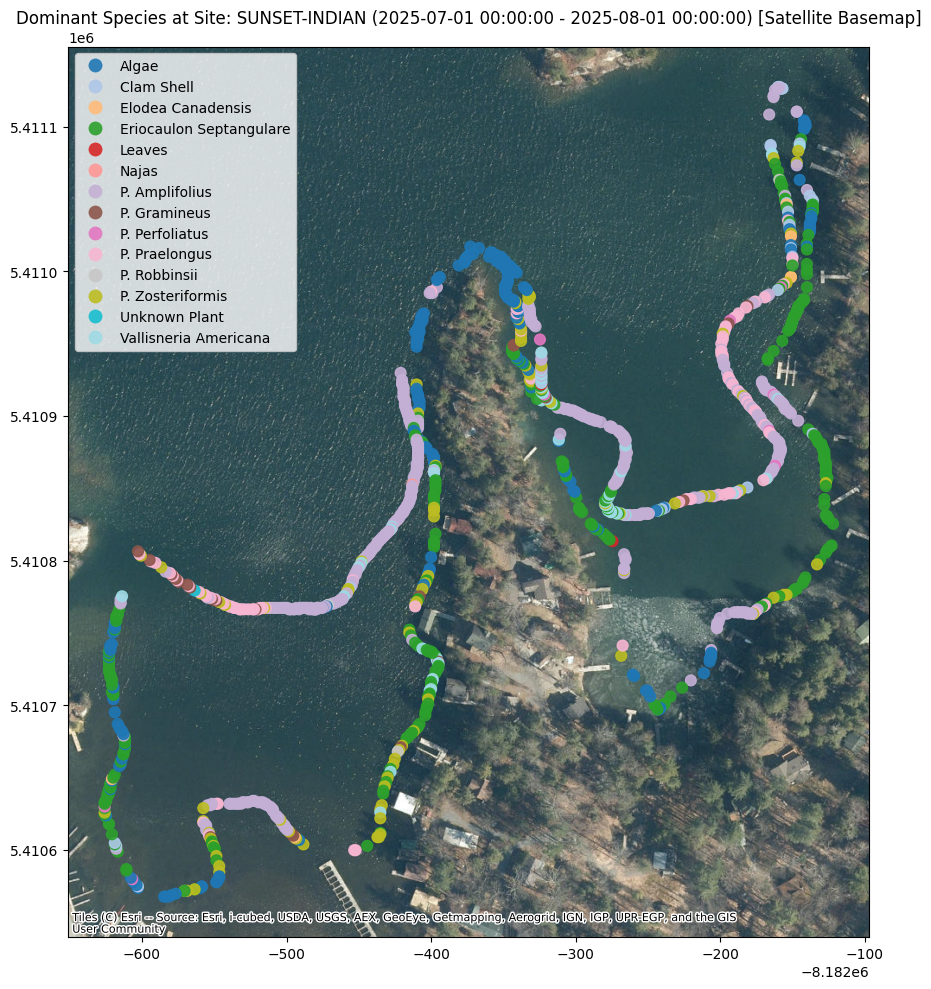

In [58]:
# Pick the site you want to visualize
site_of_interest = "SUNSET-INDIAN"
start_time = "2025-07-01 00:00:00"
end_time   = "2025-08-01 00:00:00"

# -------------------------------
# Load predictions and metadata
# -------------------------------
pred = pd.read_csv(pred_csv_path)
pred = pred[
    (pred["datetime"] >= start_time) &
    (pred["datetime"] <= end_time)
]
meta = pd.read_csv(csv_path)  # frame_path, latitude, longitude, site
meta = meta[
    (meta["datetime"] >= start_time) &
    (meta["datetime"] <= end_time)
]

# Filter both datasets to this site
pred_site = pred[pred["site"] == site_of_interest]
meta_site = meta[meta["site"] == site_of_interest]

# Merge predictions with metadata for this site
merged = pred_site.merge(meta_site, on="frame_path", how="inner")

# ----------------------------------------
# Determine dominant species per image
# ----------------------------------------
# Count detections per (image, class)
counts = (
    merged.groupby(["frame_path", "class"])
          .size()
          .reset_index(name="n_detections")
)

# Pick the class with the most detections for each image
dominant = (
    counts.sort_values(["frame_path", "n_detections"], ascending=[True, False])
          .drop_duplicates("frame_path")
)

# Merge back lat/lon for plotting
dominant = dominant.merge(meta_site, on="frame_path", how="left")

if dominant.empty:
    print(f"No dominant-species data found for site '{site_of_interest}' between {start_time} and {end_time}")
else:
    # -------------------------------
    # 1. Convert DataFrame → GeoDataFrame
    # -------------------------------
    gdf = gpd.GeoDataFrame(
        dominant,
        geometry=gpd.points_from_xy(dominant.longitude, dominant.latitude),
        crs="EPSG:4326"   # lat/lon
    )
    
    # -------------------------------
    # 2. Project to Web Mercator (needed for basemap)
    # -------------------------------
    gdf = gdf.to_crs(epsg=3857)
    
    # -------------------------------
    # 3. Plot with basemap
    # -------------------------------
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot species points
    gdf.plot(
        ax=ax,
        column="class",
        cmap="tab20",
        markersize=60,
        legend=True,
        alpha=0.9
    )
    
    # Add satellite basemap
    cx.add_basemap(
        ax,
        source=cx.providers.Esri.WorldImagery
    )
    
    plt.title(f"Dominant Species at Site: {site_of_interest} ({start_time} - {end_time}) [Satellite Basemap]")
    plt.tight_layout()
    plt.show()